In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
pip install scikit-learn

     |████████████████████████████████| 6.9MB 2.7MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


IMPORT ALL IMPORTANT LIBRARY

In [2]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.layers import Input
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from hypopt import GridSearch
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from math import ceil

#from google.colab.patches import cv2_imshow
from imutils import paths
import matplotlib.pyplot as plt
import h5py
import pickle
import numpy as np
import matplotlib.pyplot as plt
import cv2
import progressbar
import random
import pandas as pd
import os

ADDING THE SET COLLUMN TO DISTINGUISH WHICH PICTURE IS IN TRAIN/VALIDATION/TEST SET

In [26]:
df = pd.read_csv('flora.csv')
if 'SET' not in df.columns:
    #CHANGE RANDOM_STATE FROM 42 TO 1 TO FIX THE UNBALANCE DISTRIBUTION WHERE TEST SET ONLY HAS 45 SPECIES.
    df = df.sample(frac=1, random_state=1)
    df['SET'] = 'train'
    df.iloc[int(.8*len(df)):int(.9*len(df)), df.columns.get_loc('SET')] = 'test'
    df.iloc[int(.9*len(df)):len(df), df.columns.get_loc('SET')] = 'validation'
    df.to_csv('flora.csv')
    
print(df)
print(df['SET'].value_counts())

                       SPECIES    ID         SET
297            Manilkara elata  3135       train
137          Mezilaurus itauba  3307       train
1138    Araucaria angustifolia   223       train
1333     Swietenia macrophylla  4509       train
186   Machaerium paraguariense  2929       train
...                        ...   ...         ...
905               Peltogyne sp  4116  validation
1791               Hymenaea sp  2413  validation
1096    Araucaria angustifolia   205  validation
235                Dipteryx sp  1606  validation
1061       Pouteria pachycarpa  4328  validation

[1901 rows x 3 columns]
train         1520
validation     191
test           190
Name: SET, dtype: int64


HDF5 CLASS

In [2]:
class HDF5DatasetWriter:
	def __init__(self, dims, outputPath, dataKey="images", bufSize=1000):
		if os.path.exists(outputPath):
			raise ValueError("Output path exist cannot be overwritten. Manually delete the file before continue", outputPath)
		self.db = h5py.File(outputPath, "w")
		self.data = self.db.create_dataset(dataKey, dims, dtype="float")
		self.labels = self.db.create_dataset("labels", (dims[0],), dtype="int")
		self.bufSize = bufSize
		self.buffer = {"data":[], "labels":[]}
		self.idx = 0
	
	def add(self, rows, labels):
		self.buffer["data"].extend(rows)
		self.buffer["labels"].extend(labels)
		if (len(self.buffer["data"]) >= self.bufSize):
			self.flush()
	
	def flush(self):
		i = self.idx + len(self.buffer["data"])
		self.data[self.idx:i] = self.buffer["data"]
		self.labels[self.idx:i] = self.buffer["labels"]
		self.idx = i
		self.buffer = {"data":[], "labels":[]}
	
	def storeClassLabels(self, classLabels):
		dt = h5py.special_dtype(vlen=str)
		labelSet = self.db.create_dataset("label_names", (len(classLabels), ), dtype=dt)
		labelSet[:] = classLabels

	def close(self):
		if (len(self.buffer["data"])>0):
			self.flush()
		self.db.close()

EXTRACTING FEATURE FUNCTION

In [3]:
def extract_feature(ListImageNames, labels, model, le, bs, outPathHDF5):
    dataset = HDF5DatasetWriter((len(ListImageNames), 512 * 7 * 7), outPathHDF5 , dataKey="features", bufSize=1000)
    dataset.storeClassLabels(le.classes_)

    widgets = ["Extracting Features: ", progressbar.Percentage(), " ", progressbar.Bar(), " ", progressbar.ETA()]
    pbar = progressbar.ProgressBar(maxval = len(ListImageNames), widgets = widgets).start()

    for i in np.arange(0, len(ListImageNames), bs):
        batchPaths = ListImageNames[i: i + bs]
        batchLabels = labels[i: i + bs]
        batchImages = []

        for (j, singleImage) in enumerate(batchPaths):
            singleImagePath = datasetPath + singleImage
            image = load_img(singleImagePath, target_size=(224, 224))
            image = img_to_array(image)
            image = np.expand_dims(image, axis=0)

            image = imagenet_utils.preprocess_input(image)
            batchImages.append(image)

        batchImages = np.vstack(batchImages)
        features = model.predict(batchImages, batch_size=bs)
        features = features.reshape((features.shape[0], 512*7*7))
        dataset.add(features, batchLabels)
        pbar.update(i)
    dataset.close()
    pbar.finish()

EXTRACTING FEATURE USING VGG16 AND STORE THE EXTRACTED FEATURES AS HDF5 FILE

In [4]:
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

bs = 8

labelsTrain = []
labelsTest = []
labelsValidation = []
trainData = []
validationData = []
testData = []

test = {}
train = {}
val = {}

csvPath = "/home/haroldle/pythonProject/brazilflora/flora.csv"
datasetPath = "/home/haroldle/Downloads/dataset/"
outPathTrainHDF5 = "/home/haroldle/pythonProject/brazilflora/featuresTrain.hdf5"
outPathTestHDF5 = "/home/haroldle/pythonProject/brazilflora/featuresTest.hdf5"
outPathValidationHDF5 = "/home/haroldle/pythonProject/brazilflora/featuresValidation.hdf5"

dataframe = pd.read_csv(csvPath)
ListImageNames = os.listdir(datasetPath)

for eachImage in ListImageNames:
    findDot = eachImage.find('.')
    imageName = dataframe[dataframe["ID"] == int(eachImage[:findDot])]
    
    if(imageName.SET.values[0]=='train'):
        trainData.append(eachImage)
        labelsTrain.append(imageName.SPECIES.values[0])
    
    elif(imageName.SET.values[0]=='test'):
        testData.append(eachImage)
        labelsTest.append(imageName.SPECIES.values[0])
    
    else:
        validationData.append(eachImage)
        labelsValidation.append(imageName.SPECIES.values[0])

le = LabelEncoder()
labelsTrain = le.fit_transform(labelsTrain)
labelsTest = le.fit_transform(labelsTest)
labelsValidation = le.fit_transform(labelsValidation)

print("[INFO] loading network...")
model = VGG16(weights="imagenet", include_top = False)

extract_feature(trainData, labelsTrain, model, le, bs, outPathTrainHDF5)
extract_feature(testData, labelsTest, model, le, bs, outPathTestHDF5)
extract_feature(validationData, labelsValidation, model, le, bs, outPathValidationHDF5)

[INFO] loading network...


Extracting Features: 100% |#####################################| Time: 0:02:12
Extracting Features: 100% |#####################################| Time: 0:00:16
Extracting Features: 100% |#####################################| Time: 0:00:17


USING GRIDSEARCH WITH THE EXTRACTED FEATURES.

In [15]:
db = h5py.File("/home/haroldle/pythonProject/brazilflora/featuresTrain.hdf5","r")
vl = h5py.File("/home/haroldle/pythonProject/brazilflora/featuresValidation.hdf5","r")
ts = h5py.File("/home/haroldle/pythonProject/brazilflora/featuresTest.hdf5","r")

dbwvlfeatures = np.concatenate([db["features"],vl["features"]]) 
dbwvllabels = np.concatenate([db["labels"],vl["labels"]])
test_fold = np.concatenate([np.full(db["features"].shape[0], -1), np.zeros(vl["features"].shape[0], dtype=np.int8)])
cv = PredefinedSplit(test_fold)

print("[INFO] tuning hyperparameters...")
param_grid = {"C": [1, 10, 100]}
model = GridSearchCV(LogisticRegression(solver="lbfgs", multi_class="auto", max_iter=10000), param_grid, cv=cv, n_jobs=-1)
model.fit(dbwvlfeatures, dbwvllabels)

print("[INFO] evaluating...")
preds = model.predict(ts["features"])
print(classification_report(ts["labels"], preds, target_names= ts["label_names"]))

print("[INFO] saving model...")
f = open("/home/haroldle/pythonProject/brazilflora/Logistic.pickle", "wb")
f.write(pickle.dumps(model.best_estimator_))
f.close()


db.close()

[INFO] tuning hyperparameters...
[INFO] evaluating...
                             precision    recall  f1-score   support

   Acrocarpus fraxinifolius       1.00      1.00      1.00         4
     Araucaria angustifolia       1.00      1.00      1.00         1
    Aspidosperma polyneuron       1.00      1.00      1.00         3
            Aspidosperma sp       1.00      1.00      1.00         4
         Bagassa guianensis       1.00      1.00      1.00         5
Balfourodendron riedelianum       1.00      1.00      1.00         8
       Bertholletia excelsa       1.00      1.00      1.00         1
               Bowdichia sp       1.00      1.00      1.00         8
     Brosimum parinarioides       1.00      1.00      1.00         2
          Carapa guianensis       1.00      0.75      0.86         4
     Cariniana estrellensis       1.00      1.00      1.00         3
           Cedrela fissilis       1.00      1.00      1.00         2
    Cedrelinga cateniformis       1.00      1.00

PLOTTING CONFUSION MATRIX


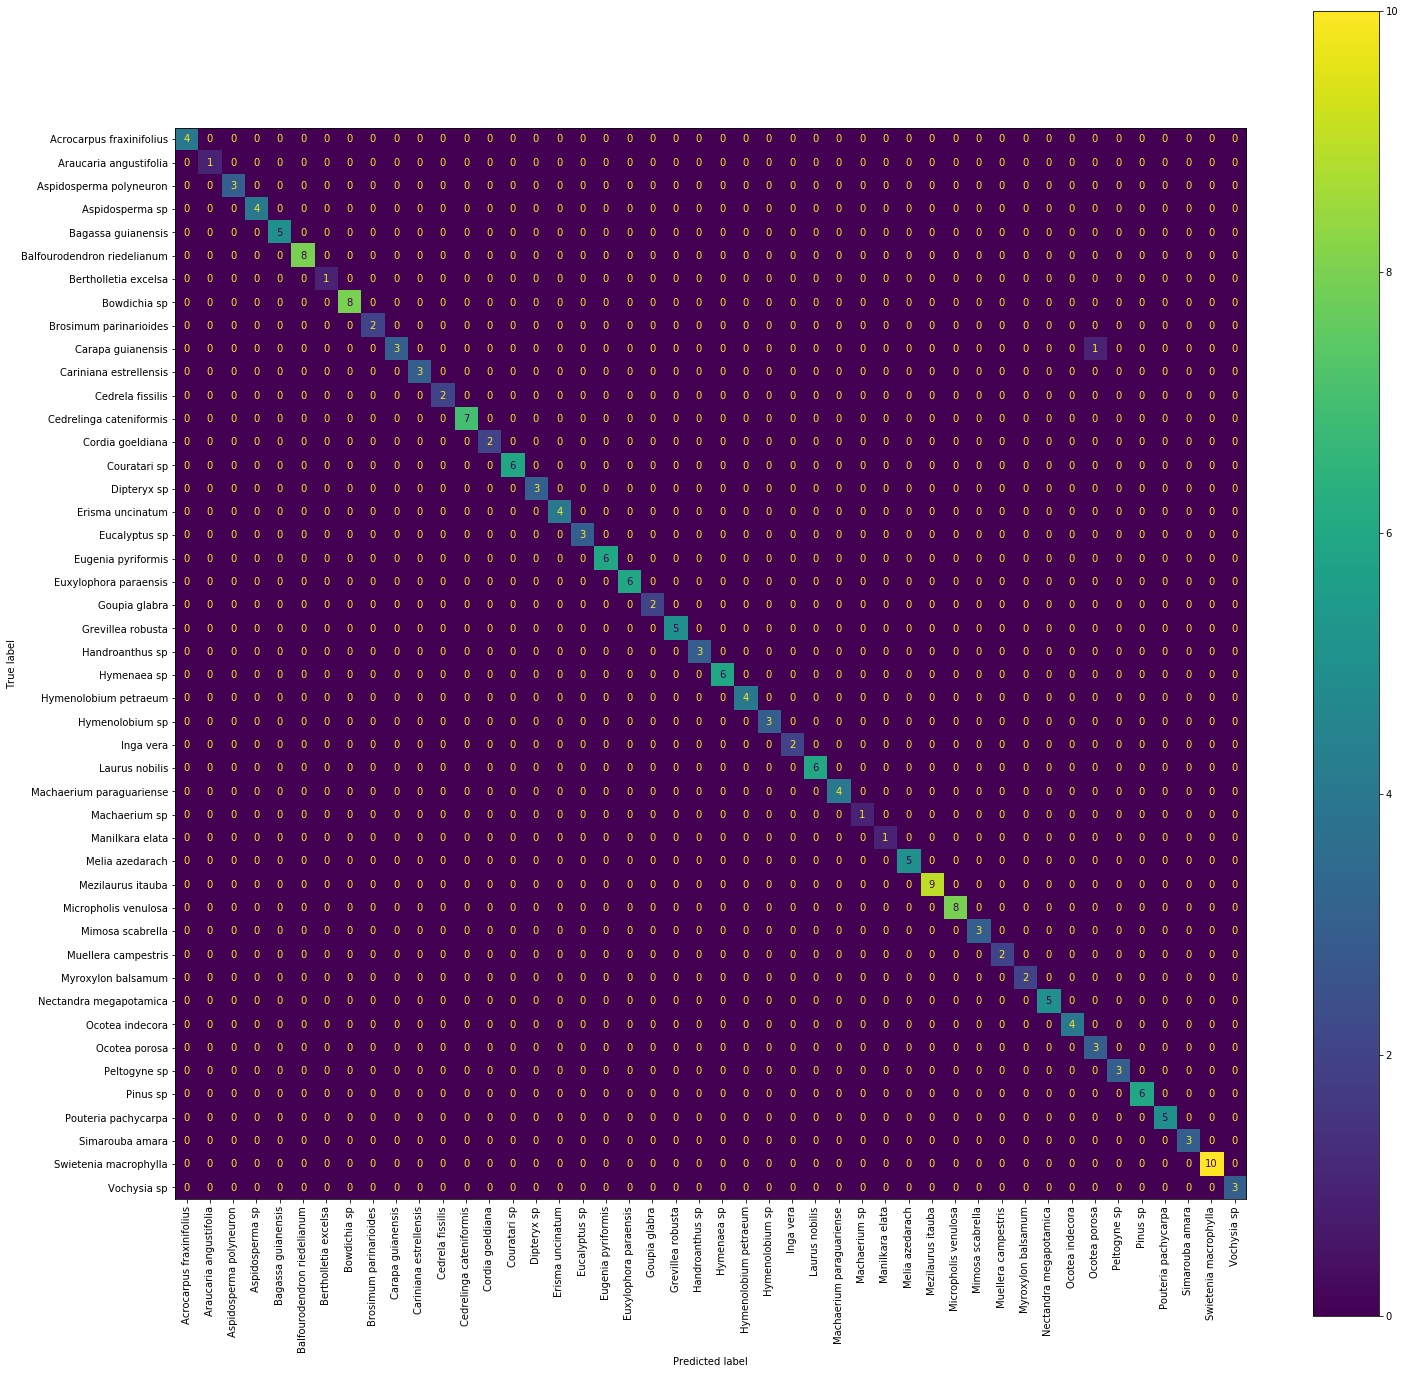

In [17]:

#LOAD THE TRAIN MODEL.
model = "/home/haroldle/pythonProject/brazilflora/Logistic.pickle"
loaded_model = pickle.load(open(model,"rb"))

#GET THE DATA SET LABELS
db = h5py.File("/home/haroldle/pythonProject/brazilflora/featuresTest.hdf5","r")

#PLOTTING THE PREDICTING DATA SET TO THE CONFUSION MATRIX
fig, ax = plt.subplots(figsize=(24, 24))
plot_confusion_matrix(loaded_model, db["features"], db["labels"], display_labels=db["label_names"], ax= ax, xticks_rotation=90)
plt.grid(False)
plt.show()



RANDOM FOREST + GRIDSEARCH + 224x224 FEATURES

In [19]:
db = h5py.File("/home/haroldle/pythonProject/brazilflora/featuresTrain.hdf5","r")
vl = h5py.File("/home/haroldle/pythonProject/brazilflora/featuresValidation.hdf5","r")
ts = h5py.File("/home/haroldle/pythonProject/brazilflora/featuresTest.hdf5","r")

dbwvlfeatures = np.concatenate([db["features"],vl["features"]]) 
dbwvllabels = np.concatenate([db["labels"],vl["labels"]])
test_fold = np.concatenate([np.full(db["features"].shape[0], -1), np.zeros(vl["features"].shape[0], dtype=np.int8)])
cv = PredefinedSplit(test_fold)

param_grid = {'n_estimators': [125, 250 ,500, 1000], 'max_depth':[10,20,40], 'max_features':['auto', 'sqrt']}
model = GridSearchCV(RandomForestClassifier(), param_grid, cv=cv, n_jobs=-1)
model.fit(dbwvlfeatures,dbwvllabels)

print("[INFO] best hyperparameter: {}".format(model.best_params_))

print("[INFO] evaluating...")
preds = model.predict(ts["features"])
print(classification_report(ts["labels"], preds, target_names=ts["label_names"]))

print("[INFO] saving model...")
f = open("/home/haroldle/pythonProject/brazilflora/RandomForest.pickle", "wb")
f.write(pickle.dumps(model.best_estimator_))
f.close()
db.close()

[INFO] best hyperparameter: {'max_depth': 20, 'max_features': 'auto', 'n_estimators': 500}
[INFO] evaluating...
                             precision    recall  f1-score   support

   Acrocarpus fraxinifolius       1.00      0.50      0.67         4
     Araucaria angustifolia       1.00      1.00      1.00         1
    Aspidosperma polyneuron       1.00      1.00      1.00         3
            Aspidosperma sp       1.00      1.00      1.00         4
         Bagassa guianensis       1.00      1.00      1.00         5
Balfourodendron riedelianum       1.00      1.00      1.00         8
       Bertholletia excelsa       0.50      1.00      0.67         1
               Bowdichia sp       1.00      1.00      1.00         8
     Brosimum parinarioides       1.00      1.00      1.00         2
          Carapa guianensis       1.00      0.25      0.40         4
     Cariniana estrellensis       1.00      1.00      1.00         3
           Cedrela fissilis       1.00      1.00      1.00 

CONFUSION MATRIX FOR RANDOM FOREST

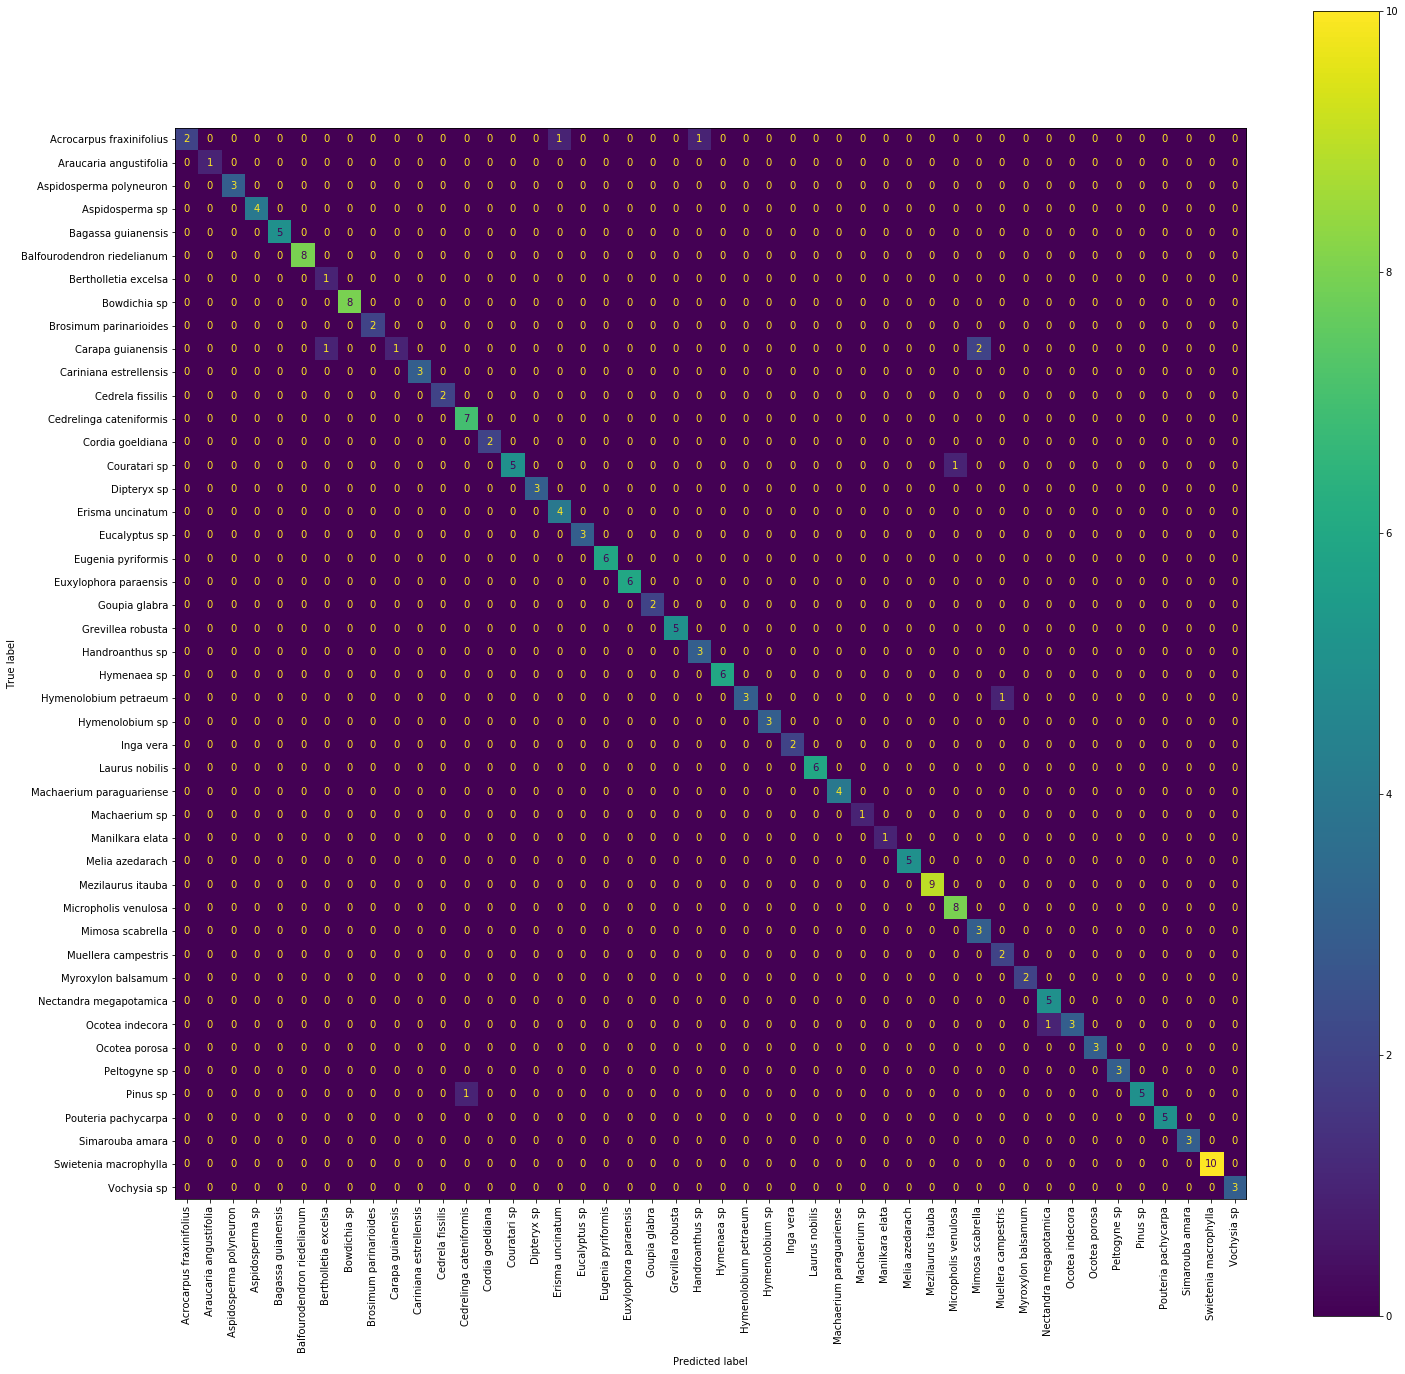

In [20]:
#LOAD THE TRAIN MODEL.
model = "/home/haroldle/pythonProject/brazilflora/RandomForest.pickle"
loaded_model = pickle.load(open(model,"rb"))

#GET THE DATA SET LABELS
db = h5py.File("/home/haroldle/pythonProject/brazilflora/featuresTest.hdf5","r")

#PLOTTING THE PREDICTING DATA SET TO THE CONFUSION MATRIX
fig, ax = plt.subplots(figsize=(24, 24))
plot_confusion_matrix(loaded_model, db["features"], db["labels"], display_labels=db["label_names"], ax= ax, xticks_rotation=90)
plt.grid(False)
plt.show()

GRIDSEARCHCV + SVM + 224x224 FEATURES

In [22]:
db = h5py.File("/home/haroldle/pythonProject/brazilflora/featuresTrain.hdf5","r")
vl = h5py.File("/home/haroldle/pythonProject/brazilflora/featuresValidation.hdf5","r")
ts = h5py.File("/home/haroldle/pythonProject/brazilflora/featuresTest.hdf5","r")

dbwvlfeatures = np.concatenate([db["features"],vl["features"]]) 
dbwvllabels = np.concatenate([db["labels"],vl["labels"]])
test_fold = np.concatenate([np.full(db["features"].shape[0], -1), np.zeros(vl["features"].shape[0], dtype=np.int8)])
cv = PredefinedSplit(test_fold)

param_grid = {'C': [1, 10, 100],  'gamma': ["auto", "scale"], 'kernel': ['rbf']}
grid = GridSearchCV(SVC(decision_function_shape='ovo'), param_grid, cv= cv, n_jobs=-1)
grid.fit(dbwvlfeatures, dbwvllabels)

print("[INFO] evaluating...")
preds = grid.predict(ts["features"])
print(classification_report(ts["labels"], preds, target_names=ts["label_names"]))

print("[INFO] saving model...")
f = open("/home/haroldle/pythonProject/brazilflora/SVMFeature.pickle", "wb")
f.write(pickle.dumps(grid.best_estimator_))
f.close()


[INFO] evaluating...
                             precision    recall  f1-score   support

   Acrocarpus fraxinifolius       1.00      1.00      1.00         4
     Araucaria angustifolia       1.00      1.00      1.00         1
    Aspidosperma polyneuron       1.00      1.00      1.00         3
            Aspidosperma sp       1.00      1.00      1.00         4
         Bagassa guianensis       1.00      1.00      1.00         5
Balfourodendron riedelianum       1.00      1.00      1.00         8
       Bertholletia excelsa       0.50      1.00      0.67         1
               Bowdichia sp       1.00      1.00      1.00         8
     Brosimum parinarioides       1.00      1.00      1.00         2
          Carapa guianensis       1.00      0.75      0.86         4
     Cariniana estrellensis       1.00      1.00      1.00         3
           Cedrela fissilis       1.00      1.00      1.00         2
    Cedrelinga cateniformis       1.00      1.00      1.00         7
           C

CONFUSION MATRIX SVM 224x224 FEATURES

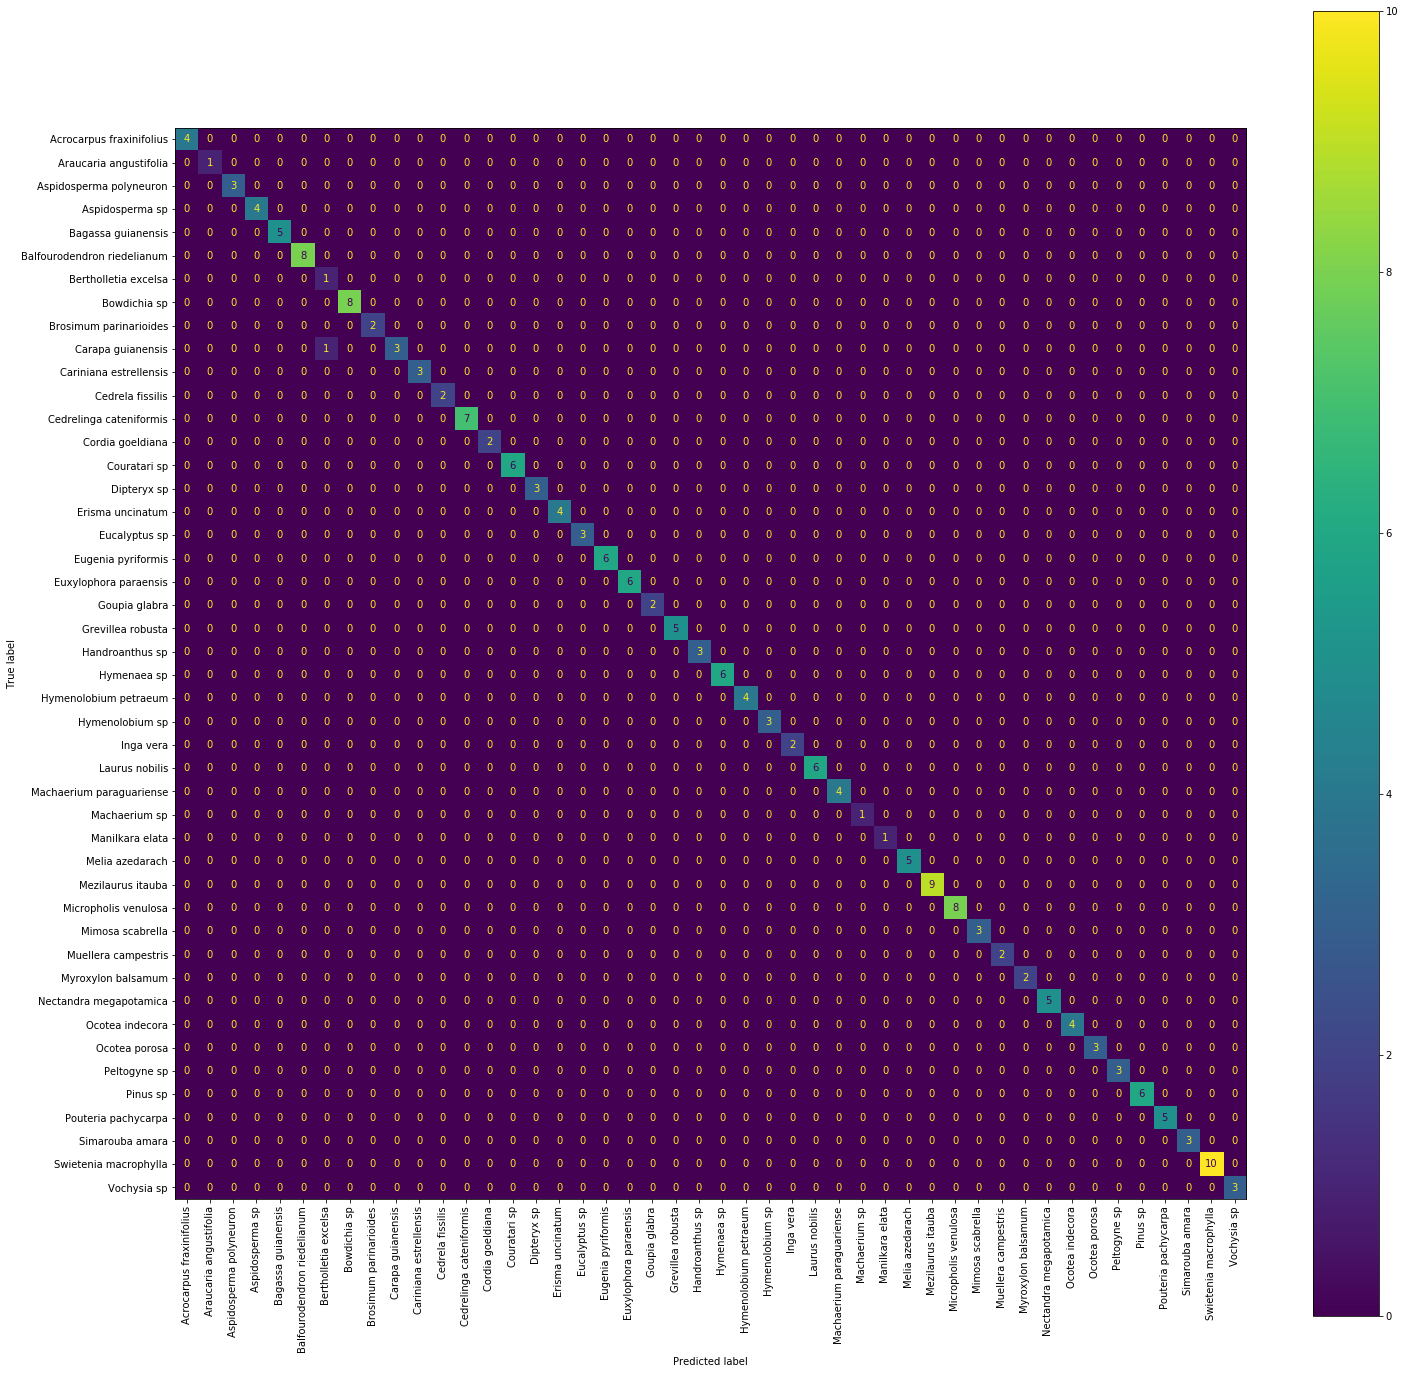

In [25]:
#LOAD THE TRAIN MODEL.
model = "/home/haroldle/pythonProject/brazilflora/SVMFeature.pickle"
loaded_model = pickle.load(open(model,"rb"))

#GET THE DATA SET LABELS
db = h5py.File("/home/haroldle/pythonProject/brazilflora/featuresTest.hdf5","r")

#PLOTTING THE PREDICTING DATA SET TO THE CONFUSION MATRIX
fig, ax = plt.subplots(figsize=(24, 24))
plot_confusion_matrix(loaded_model, db["features"], db["labels"], display_labels=db["label_names"], ax= ax, xticks_rotation=90)
plt.grid(False)
plt.show()

(OLD CODE - FUTURE) EXTRACTING FEATURE WITH SMALLER INPUT 128X128 => USE A ML MODEL TO LEARN => CODE FOR TESTING

FEATURE EXTRACTION USING VGG16 WITH SMALLER INPUT 128X128

In [11]:
bs = 32
labels = []

'''
imagePaths = list(paths.list_images(args["dataset"]))
random.shuffle(imagePaths)
labels = [p.split(os.path.sep)[-2] for p in imagePaths]
'''
#After mounting the google drive
#something like /content/drive/
csvPath = "/content/drive/My Drive/Colab_Notebooks/python code/flora.csv"
datasetPath = "/content/drive/My Drive/cc78ftcdf9-1/"
outPathHDF5 = "/content/drive/My Drive/Colab_Notebooks/features_128x128res.hdf5"

dataframe = pd.read_csv(csvPath)
ListImageNames = os.listdir(datasetPath)

random.shuffle(ListImageNames)

for eachImage in ListImageNames:
	findDot = eachImage.find('.')
	imageName = dataframe[dataframe["ID"] == int(eachImage[:findDot])]
	labels.append(imageName.SPECIES.values[0])
le = LabelEncoder()
labels = le.fit_transform(labels)

print("[INFO] loading network...")
model = VGG16(weights="imagenet", include_top = False, input_tensor=Input(shape=(128,128,3)))

dataset = HDF5DatasetWriter((len(ListImageNames), 512 * 4 * 4), outPathHDF5 , dataKey="features", bufSize=1000)
dataset.storeClassLabels(le.classes_)

widgets = ["Extracting Features: ", progressbar.Percentage(), " ", progressbar.Bar(), " ", progressbar.ETA()]
pbar = progressbar.ProgressBar(maxval = len(ListImageNames), widgets = widgets).start()
for i in np.arange(0, len(ListImageNames), bs):
	batchPaths = ListImageNames[i: i + bs]
	batchLabels = labels[i: i + bs]
	batchImages = []
	
	for (j, singleImage) in enumerate(batchPaths):
		singleImagePath = datasetPath + singleImage
		image = load_img(singleImagePath, target_size=(128, 128))
		image = img_to_array(image)
		image = np.expand_dims(image, axis=0)
		image = imagenet_utils.preprocess_input(image)
		batchImages.append(image)
  
	batchImages = np.vstack(batchImages)
	features = model.predict(batchImages, batch_size=bs)
	features = features.reshape((features.shape[0], 512*4*4))
	dataset.add(features, batchLabels)
	pbar.update(i)
dataset.close()
pbar.finish()

FileNotFoundError: [Errno 2] File b'/content/drive/My Drive/Colab_Notebooks/python code/flora.csv' does not exist: b'/content/drive/My Drive/Colab_Notebooks/python code/flora.csv'

USING LOGISTIC REGRESSION WITH CROSS VALIDATION AND SAGA SOLVER VGG16 224x224

In [3]:
db = h5py.File("/home/haroldle/pythonProject/brazilflora/featuresTrain.hdf5","r")

print("[INFO] tuning hyperparameters...")
model = LogisticRegressionCV(solver="saga", multi_class="auto", cv=3, max_iter=10000, n_jobs=-1)
model.fit(db["features"][:i], db["labels"][:i])

print("[INFO] saving model...")
f = open("/home/haroldle/pythonProject/brazilflora/LogisticCV_model_224.pickle", "wb")
f.write(pickle.dumps(model.best_estimator_))
f.close()

db.close()

[INFO] tuning hyperparameters...


KeyboardInterrupt: 

CREATE A SIMPLE PROGRAM TO TEST THE TRAINING MODEL.

In [ ]:
testImagePath = "/content/drive/My Drive/Colab_Notebooks/dataset/cc78ftcdf9-1/1-Acrocarpus fraxinifolius/0101.jpg"
#GET THE DATA SET LABELS
db = h5py.File("/content/drive/My Drive/Colab_Notebooks/python code/features_low_res.hdf5","r")

#LOAD THE TRAIN MODEL.
model = "/content/drive/My Drive/Colab_Notebooks/python code/floras_low_res.pickle"
loaded_model = pickle.load(open(model,"rb"))

#LOAD A VGG16 MODEL WITH INPUT OF 224X224
model = VGG16(weights="imagenet", include_top = False, input_tensor=Input(shape=(128,128,3)))

#AUGMENTING THE IMAGE - BLURRING THE IMAGE USING GAUSSIANBLUR 5X5 FILTER
image = cv2.imread(testImagePath)
image = cv2.resize(image, (128,128),interpolation = cv2.INTER_AREA)
image = cv2.GaussianBlur(image, (5,5), 0)
cv2_imshow(image)

#PREPROCESS THE IMAGE
image = np.expand_dims(image, axis = 0)
image = imagenet_utils.preprocess_input(image)

#EXTRACTING FEATURE OF THE PREPROCESS IMAGE 
features = model.predict(image, batch_size = 1)
features = features.reshape((features.shape[0], 512*4*4))

preds = loaded_model.predict(features)
print(db["label_names"][preds])

PLOTTING TRAINING OR TESTING DATASET DISTRIBUTION IN BAR GRAPH

IndexError: tuple index out of range

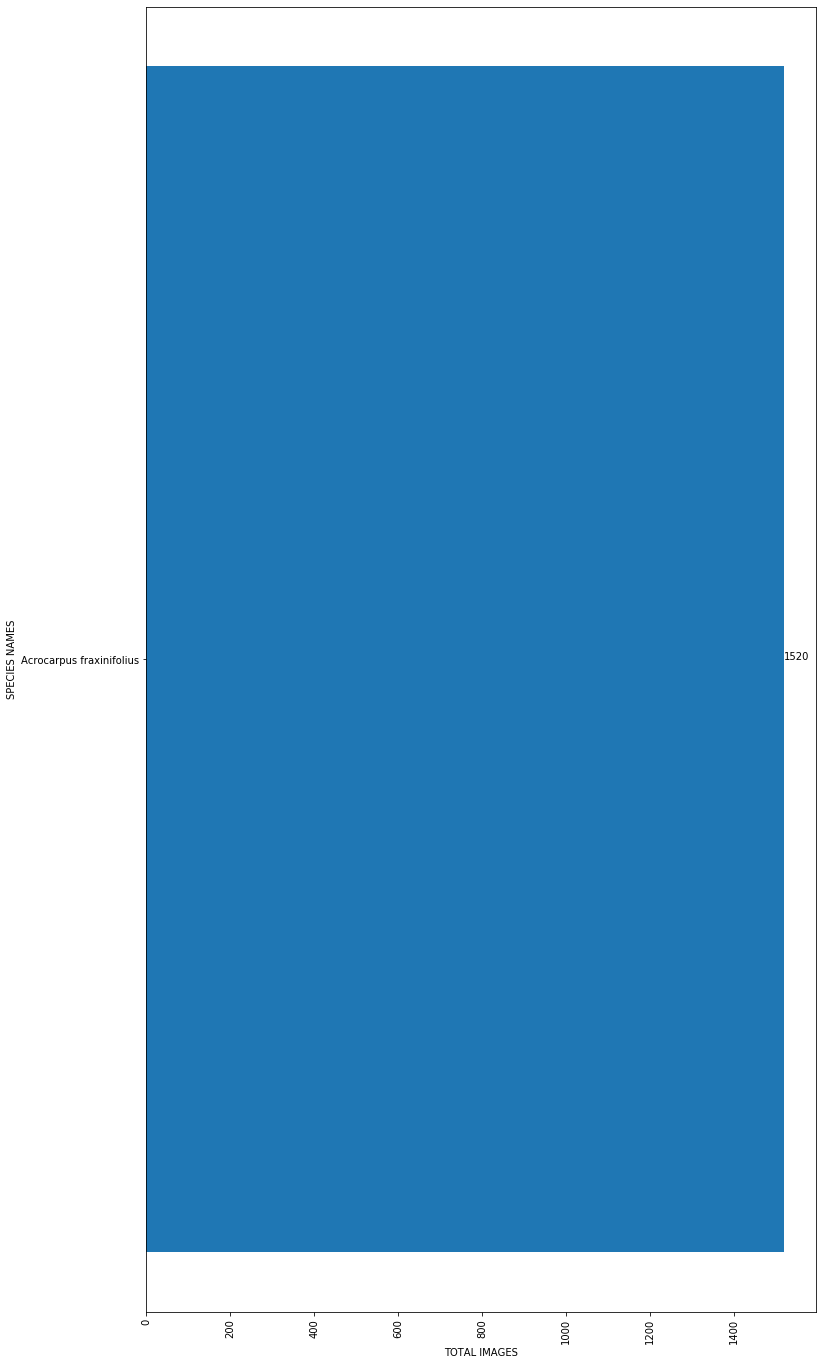

In [19]:
fig, ax = plt.subplots(figsize=(12, 24))

label = {}

db = h5py.File("/home/haroldle/pythonProject/brazilflora/featuresTrain.hdf5","r")
i = int(db["labels"].shape[0])
#WARNING Either 1 for loop can be uncommented
#UNCOMMENTING For loop below for plotting the training data distribution
for j in range(i):
#UNCOMMENTING For loop below for plotting the test data distribution
#for j in range(i, db["labels"].shape[0]):
    if (not (db["label_names"][db["labels"][j]] in label.keys())):
        label[db["label_names"][db["labels"][j]]] = 1
    else:
        label[db["label_names"][db["labels"][j]]] += 1

labels, values = zip(*sorted(label.items(), reverse=True))
plt.barh(labels, values)
#ax.bar(labels, values)
plt.xticks(rotation=90)
plt.xlabel("TOTAL IMAGES")
plt.ylabel("SPECIES NAMES")
for i in range(46):
    plt.text(values[i],i,str(values[i]))
plt.show()
